In [1]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

In [2]:
from utils import base_configs, deps, tr_va_te_split #, models_def, shap_explain
from utils.helpers import rw_csv_helpers, feature_distr_helpers, logging_helpers, tr_va_te_eval_helpers, tr_va_te_result_plot

In [3]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
CONFIGS = base_configs.get_base_configs()
# path to your global SHAP file

#SWITCH THE FOLLOWING ACCORDINGLY
CONFIGS["RUN_TS"] = "20251202_200541"

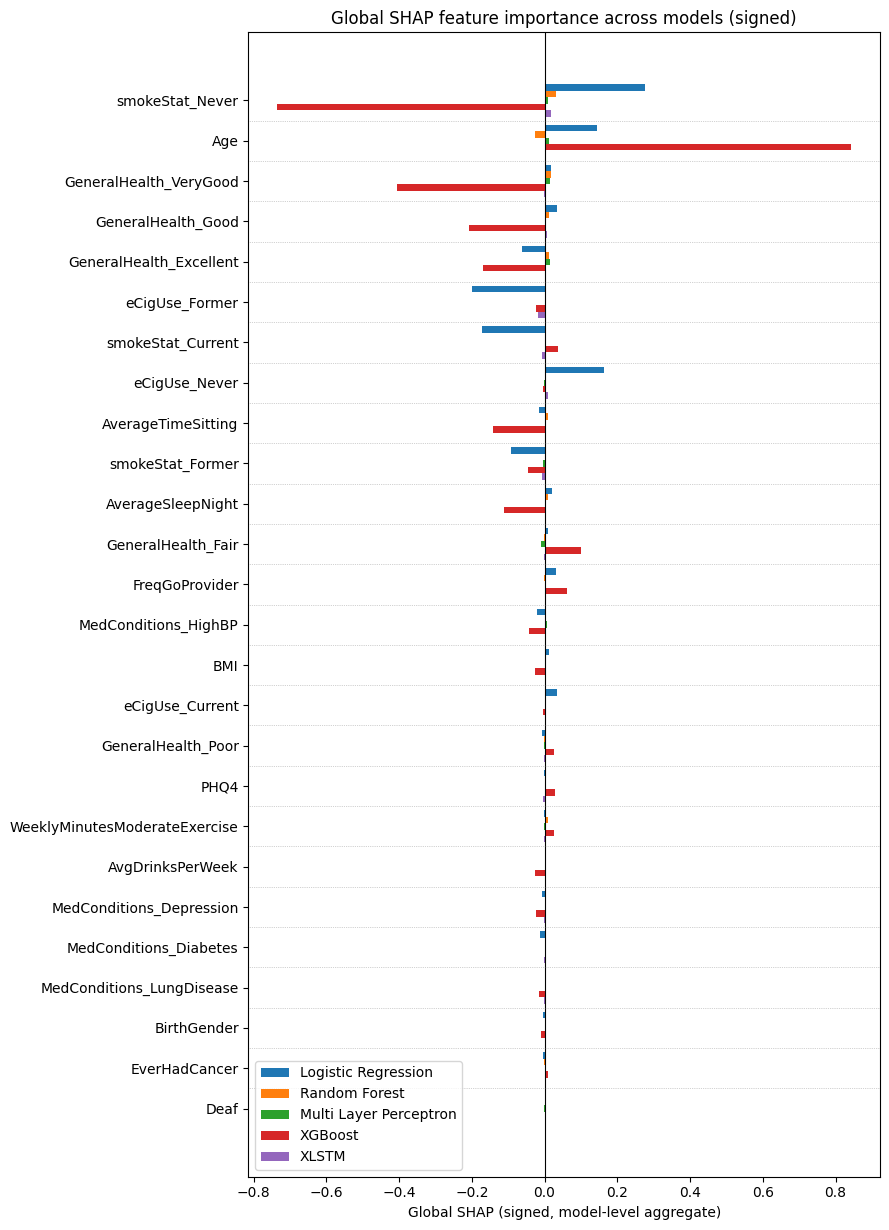

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Read global SHAP file (one row per feature)
global_csv_path = f"op/tr_va_te_metric_shap_{CONFIGS['RUN_TS']}/global_shap_{CONFIGS['RUN_TS']}.csv"

gdf = pd.read_csv(global_csv_path)

# 2. Model labels
model_index = {
    "lr":    "Logistic Regression",
    "rf":    "Random Forest",
    "mlp":   "Multi Layer Perceptron",
    "xgb":   "XGBoost",
    "xlstm": "XLSTM"
}

# 3. Keep only models that actually have "<model>_shap" columns (signed)
importance_cols = {
    short: f"{short}_shap"
    for short in model_index.keys()
    if f"{short}_shap" in gdf.columns
}

if not importance_cols:
    raise ValueError("No *_shap columns found in the global SHAP file.")

# 4. Rank features by mean absolute SHAP across models (for ordering only)
gdf["mean_abs_importance"] = gdf[list(importance_cols.values())].abs().mean(axis=1)

# use all features, ordered from most to least important
gdf_sorted = gdf.sort_values("mean_abs_importance", ascending=False)

features = gdf_sorted["feature"].tolist()
n_features = len(features)
n_models = len(importance_cols)

# 5. Grouped horizontal bar plot with signed SHAP values
fig, ax = plt.subplots(figsize=(9, 0.4 * n_features + 2))  # height scales with #features

y_pos = np.arange(n_features)
total_height = 0.8           # total band height per feature
bar_height = total_height / n_models

for i, (short_name, col_name) in enumerate(importance_cols.items()):
    long_name = model_index[short_name]

    # vertical offsets for groups
    offsets = y_pos - total_height/2 + i * bar_height + bar_height/2

    ax.barh(
        offsets,
        gdf_sorted[col_name].values,   # signed SHAP
        height=bar_height,
        label=long_name
    )

# y-axis: one tick per feature
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # highest-importance feature on top

# vertical zero line for sign reference
ax.axvline(0, color="black", linewidth=0.8)

# 6. horizontal lines between features
for y in np.arange(n_features - 1) + 0.5:
    ax.axhline(y, linestyle=":", linewidth=0.5, color="gray", alpha=0.7)

ax.set_xlabel("Global SHAP (signed, model-level aggregate)")
ax.set_title("Global SHAP feature importance across models (signed)")
ax.legend()
plt.tight_layout()
plt.show()


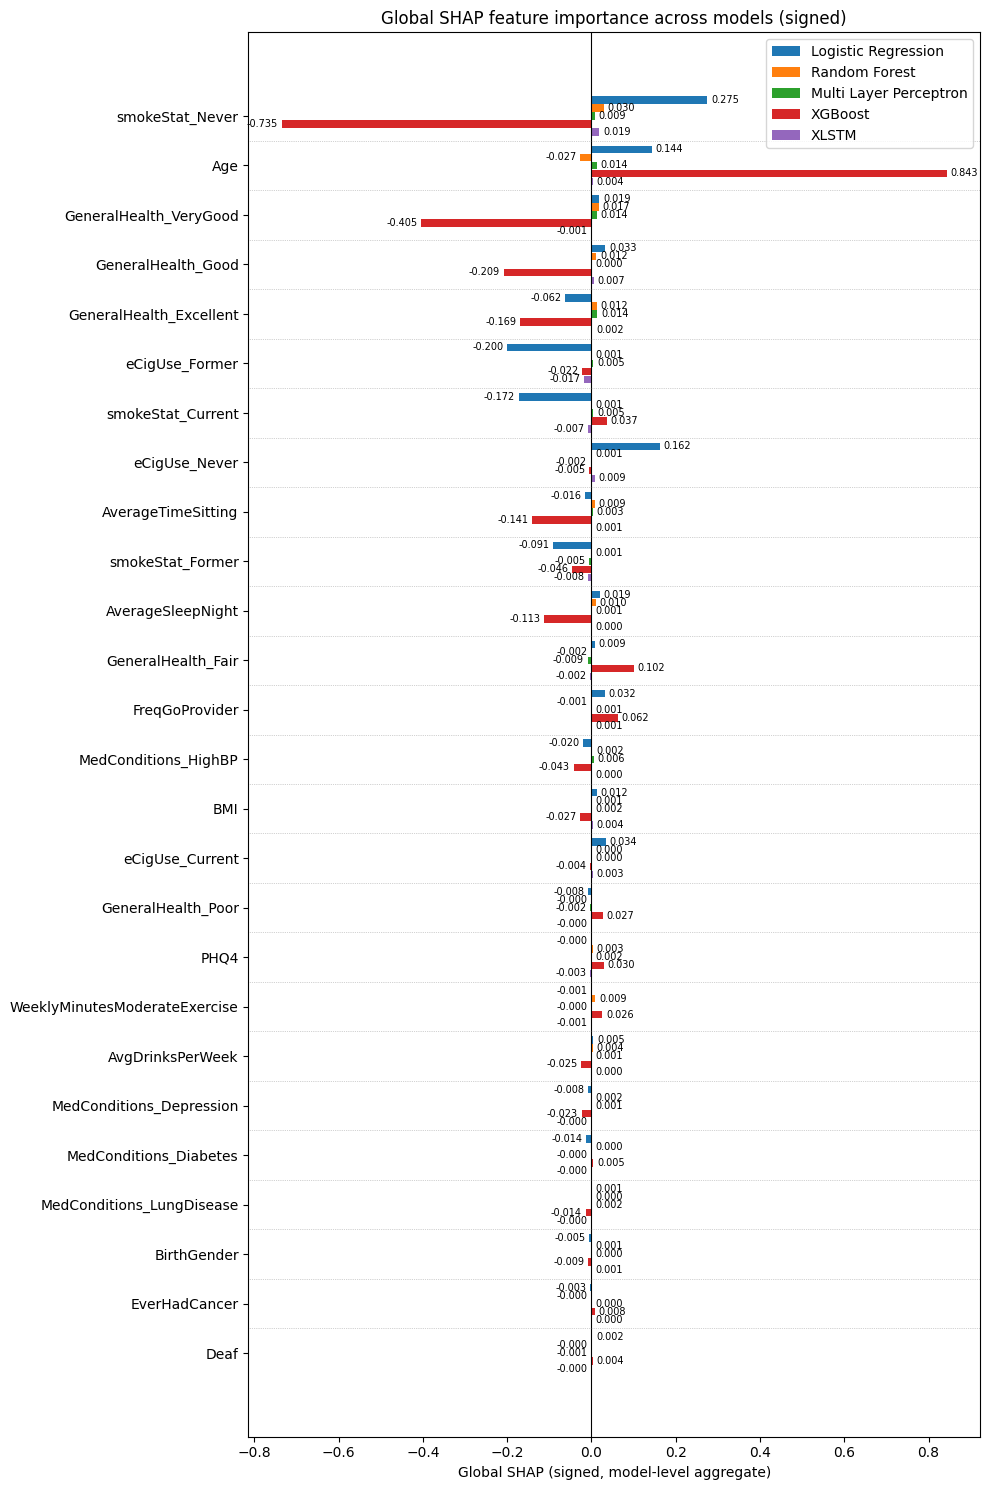

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Read global SHAP file (one row per feature)
global_csv_path = f"op/tr_va_te_metric_shap_" + CONFIGS['RUN_TS'] + "/global_shap_" + CONFIGS['RUN_TS'] + ".csv"
gdf = pd.read_csv(global_csv_path)

# 2. Model labels
model_index = {
    "lr":    "Logistic Regression",
    "rf":    "Random Forest",
    "mlp":   "Multi Layer Perceptron",
    "xgb":   "XGBoost",
    "xlstm": "XLSTM"
}

# 3. Keep only models that actually have "<model>_shap" columns (signed)
importance_cols = {
    short: f"{short}_shap"
    for short in model_index.keys()
    if f"{short}_shap" in gdf.columns
}

if not importance_cols:
    raise ValueError("No *_shap columns found in the global SHAP file.")

# 4. Rank features by mean absolute SHAP across models (for ordering only)
gdf["mean_abs_importance"] = gdf[list(importance_cols.values())].abs().mean(axis=1)

# use all features, ordered from most to least important
gdf_sorted = gdf.sort_values("mean_abs_importance", ascending=False)

features = gdf_sorted["feature"].tolist()
n_features = len(features)
n_models = len(importance_cols)

# 5. Grouped horizontal bar plot with signed SHAP values
fig, ax = plt.subplots(figsize=(10, 0.5 * n_features + 2))

# center y position of each feature block, with extra spacing between blocks
feature_spacing = 1.6                      # > 1.0 to create visible gaps between features
y_pos = np.arange(n_features) * feature_spacing

# --- thickness + spacing setup ---
# doubled bar thickness compared to previous 0.12
bar_height = 0.24                          # thickness of each bar
inner_gap = 0.02                           # gap between bars within same feature block
total_height = n_models * bar_height + (n_models - 1) * inner_gap

# For label positioning
all_vals = gdf_sorted[list(importance_cols.values())].values
x_max = np.nanmax(np.abs(all_vals)) if all_vals.size > 0 else 1.0
label_offset = 0.01 * x_max                # small offset from bar end

for i, (short_name, col_name) in enumerate(importance_cols.items()):
    long_name = model_index[short_name]
    vals = gdf_sorted[col_name].values  # signed SHAP for this model

    # Center of block = y_pos; distribute bars within [y - total_height/2, y + total_height/2]
    offsets = (
        y_pos
        - total_height / 2
        + i * (bar_height + inner_gap)
        + bar_height / 2
    )

    bars = ax.barh(
        offsets,
        vals,
        height=bar_height,
        label=long_name
    )

    # Add value labels on each bar
    for x, y in zip(vals, offsets):
        if np.isnan(x):
            continue
        ha = "left" if x >= 0 else "right"
        x_text = x + (label_offset if x >= 0 else -label_offset)
        ax.text(
            x_text,
            y,
            f"{x:.3f}",
            va="center",
            ha=ha,
            fontsize=7
        )

# y-axis: one tick per feature (center of each block)
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # highest-importance feature on top

# vertical zero line for sign reference
ax.axvline(0, color="black", linewidth=0.8)

# horizontal separator lines in the empty space between feature blocks
for i in range(n_features - 1):
    mid = (y_pos[i] + y_pos[i + 1]) / 2.0
    ax.axhline(mid, linestyle=":", linewidth=0.5, color="gray", alpha=0.7)

ax.set_xlabel("Global SHAP (signed, model-level aggregate)")
ax.set_title("Global SHAP feature importance across models (signed)")
ax.legend()
plt.tight_layout()
plt.show()
